In [1]:
import sys
# setting path
sys.path.append('..')
# importing
from qiskit import transpile
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit import Aer, execute, IBMQ, BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import Shor_library

In [2]:
"""The Montreal device has 27 qubits and a QV of 128"""
from qiskit.test.mock import FakeMontreal
device_backend = FakeMontreal()


In [3]:
"""We have to create the circuit as done using the library (sequential version)"""
def circuit_creator(n,N,a):
    aux = QuantumRegister(n+1)
    up_reg = QuantumRegister(1)
    c_aux = ClassicalRegister(1)
    down_reg = QuantumRegister(n)
    up_classic = ClassicalRegister(2*n)
    circuit = QuantumCircuit(down_reg , up_reg , aux, up_classic,c_aux)
    circuit.x(down_reg[0])
    for i in range(0, 2*n):
        circuit.x(up_reg).c_if(c_aux, 1)
        circuit.h(up_reg)
        Shor_library.Ua_inplace(circuit, up_reg[0:1], down_reg, aux, a**(2**(2*n-1-i)), N, n)
        for j in range(0, 2**i):
            circuit.p(Shor_library.getAngle(j, i), up_reg[0]).c_if(up_classic, j)
        circuit.h(up_reg)
        circuit.measure(up_reg[0], up_classic[i])
        circuit.measure(up_reg[0], c_aux[0])
    return circuit

In [4]:
N=3*5
a=8
n=4
number_shots=100

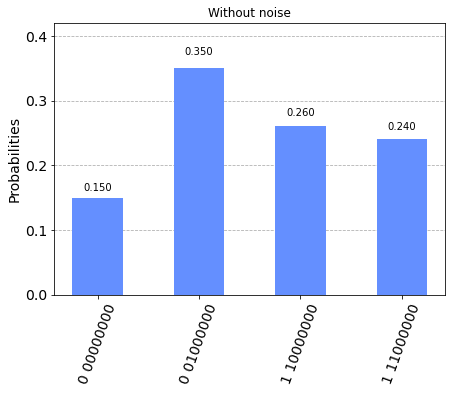

In [5]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
circuit = circuit_creator(n,N,a)
simulation = execute(circuit , backend=backend ,shots=number_shots)
result = simulation.result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Without noise')

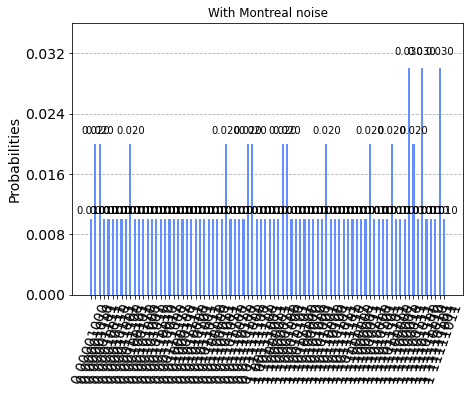

In [13]:
noise_model = NoiseModel.from_backend(device_backend)
coupling_map = device_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates
# Execute and get counts
result_noise = execute(circuit_creator(n,N,a), backend,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,shots=number_shots).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise, title='With Montreal noise')